In [3]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [23]:
import numpy as np
import torch
import torch.nn.functional as F
import tiktoken
import logging
import json
from time import time
from safetensors import safe_open
from model import FlashSTU
from config import FlashSTUConfig
import torch.nn as nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int, 
    K: int, 
    use_hankel_L: bool = False, 
    device: torch.device = None,
    dtype: torch.dtype = torch.float,
) -> torch.Tensor:
    # assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


Using device: cpu


In [44]:
def exponential_decay_init(size, lam=5.0):
    """
    Samples from an exponential distribution with rate lam, 
    then clips at 1, does (1 - clipped_value),
    and finally multiplies by ±1 with probability 1/2.
    """
    # 1) Sample uniform [0,1], convert to exponential
    u = torch.rand(size)
    x = -1.0 / lam * torch.log(1 - u)  # Exponential(λ = lam)

    # 2) Clip at 1
    x = torch.clamp(x, max=1.0)

    # 3) Subtract from 1 (to be near 1 for small x)
    x = 1.0 - x  # Now we have distribution mostly near 1 for large lam

    # 4) Multiply by ±1 with prob 1/2
    sign = torch.sign(torch.randn(size))
    return x * sign

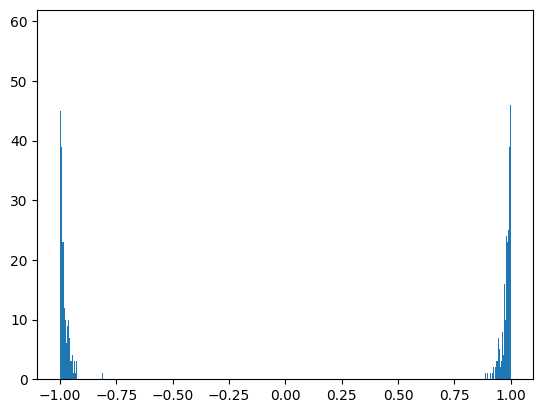

In [57]:
_ = plt.hist(exponential_decay_init(1000, lam = 50.0).detach().cpu().numpy(), bins = 1000)

In [24]:
K = 20
seq_len = 1024
phi = get_spectral_filters(seq_len, K)

In [61]:
class ExpSet(nn.Module):
    def __init__(self, state_dim):
        super(ExpSet, self).__init__()
        self.A = nn.Parameter(torch.rand(state_dim) * 2 - 1) #perhaps bias to (1 or -1)
        # self.A = nn.Parameter(exponential_decay_init(state_dim, lam = 200.0))
        self.coeffs = nn.Parameter(torch.rand(state_dim) / (1000 * state_dim))

    def forward(self, seq_len = 1024):
        # Compute powers for each element in A
        powers = torch.arange(seq_len, device=self.A.device)  # [0, 1, 2, ..., seq_len-1]
        A_expanded = self.A[:, None]  # [state_dim, 1]
        A_powers = A_expanded ** powers  # [state_dim, seq_len]
        coeffs = self.coeffs[:, None]
        A_powers = A_powers * coeffs
        
        # Sum across state dimension
        return A_powers.sum(dim=0)  # [seq_len]

    def compute_loss(self, filter):
        output = self.forward()
        mse_loss = nn.MSELoss()
        return mse_loss(output, filter)
    

In [77]:
class LDS(nn.Module):
    def __init__(self, state_dim):
        super(LDS, self).__init__()
        self.state_dim = state_dim
        
        self.A = nn.Parameter(exponential_decay_init([state_dim], lam = 15))
        self.B = nn.Parameter(torch.randn(1, state_dim) / 1000)
        self.C = nn.Parameter(torch.randn(state_dim, 1) / state_dim)
        # self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))

    def forward(self, seq_len = 1024):
        # Initialize output tensor
        outputs = torch.zeros(seq_len)
        
        # For each position
        for i in range(seq_len):
            # Compute A^i
            a_power = self.A ** i
            
            # Multiply C[:,0] * A^i * B[i]
            outputs[i] = torch.sum(self.C[:,0] * a_power * self.B[0])
            
        return outputs

    def compute_loss(self, filter):
        output = self.forward()
        mse_loss = nn.MSELoss()
        return mse_loss(output, filter)

In [80]:
import copy

model = LDS(10000)
steps = 100000
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
best_loss = 1e10
best_model = None

for i in range(steps):
    optimizer.zero_grad()
    loss = model.compute_loss(phi[:, 0])
    loss.backward()
    optimizer.step()
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model = copy.deepcopy(model)
    if i % 100 == 0:
        print(f"Step {i+1}, Loss: {loss.item()}")


Step 1, Loss: 1.0165055464028683e-09
Step 101, Loss: 9.577735271548704e-10
Step 201, Loss: 9.569907089002072e-10
Step 301, Loss: 9.565657155263807e-10
Step 401, Loss: 9.562163283405312e-10
Step 501, Loss: 9.558849267676806e-10
Step 601, Loss: 9.55526879842239e-10
Step 701, Loss: 9.550270574365527e-10
Step 801, Loss: 9.539662393365234e-10
Step 901, Loss: 9.503980935576806e-10
Step 1001, Loss: 9.161339464824891e-10
Step 1101, Loss: 8.777830129425013e-10
Step 1201, Loss: 8.620505420608993e-10
Step 1301, Loss: 9.514052878856205e-10
Step 1401, Loss: 8.420055208624433e-10
Step 1501, Loss: 8.397100237367283e-10
Step 1601, Loss: 8.376105364860109e-10
Step 1701, Loss: 8.469606127547991e-10
Step 1801, Loss: 8.267042606036057e-10
Step 1901, Loss: 8.259506412144901e-10
Step 2001, Loss: 8.28230983795919e-10
Step 2101, Loss: 8.205410795270041e-10
Step 2201, Loss: 8.260441219931636e-10
Step 2301, Loss: 8.192205802615149e-10
Step 2401, Loss: 8.347830759980468e-10
Step 2501, Loss: 8.154272812532781e-10

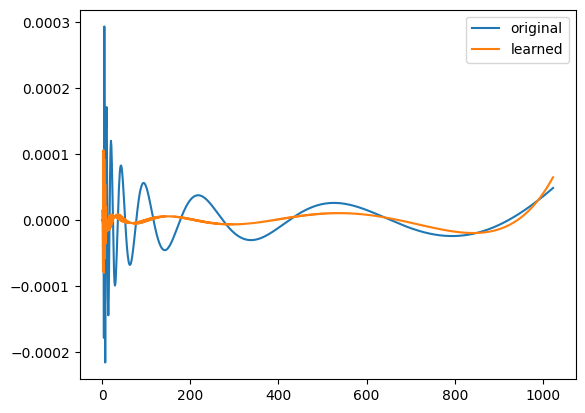

In [81]:
import matplotlib.pyplot as plt
plt.plot(phi[:, 0], label = "original")
plt.plot(best_model.forward().detach().cpu().numpy(), label = "learned")
plt.legend()
plt.show()

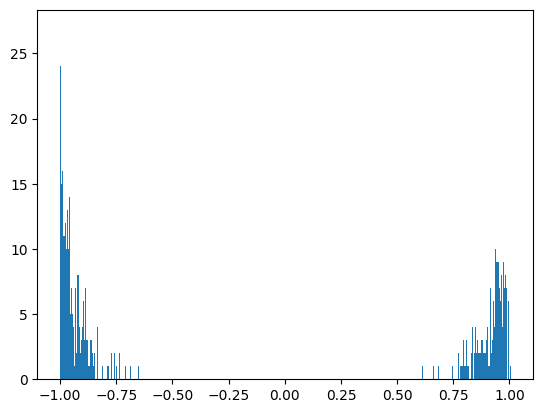

In [86]:
_ = plt.hist(best_model.A.detach().cpu().numpy(), bins = 1000)

In [85]:
best_model.C.abs().mean()

tensor(0.0024, grad_fn=<MeanBackward0>)